In [3]:
import pandas as pd
import numpy as np
import scipy.spatial.distance as scidist
from scipy.stats import zscore
from sklearn.preprocessing import normalize
import json
import os
import random
import re

# Installation

Go to [https://datasets.imdbws.com/](https://datasets.imdbws.com/), download `title.basics.tsv.gz` and `title.ratings.tsv.gz`, unzip into this folder. For the covers, go to [http://mmcv.csie.ncku.edu.tw/~wtchu/projects/MoviePoster/](http://mmcv.csie.ncku.edu.tw/~wtchu/projects/MoviePoster/), download the Movie Poster Dataset, throw all images into a folder "covers" (e.g., with `mv ~/Downloads/Movie_Poster_Dataset/**/*.jpg data/imdb/covers`).

In [4]:
ratings = pd.read_csv('title.ratings.tsv', sep='\t')
movies = pd.read_csv('title.basics.tsv', sep="\t", header=0, converters={
    # sucks, but it's mixed data everywhere
    'tconst': str,
    'titleType': str,
    'primaryTitle': str,
    'originalTitle': str,
    'isAdult': str,
    'startYear': str,
    'endYear': str,
    'runtimeMinutes': str,
    'genres': str,
})


In [32]:
# filter for no porn and yes movies
movies = movies.query('(isAdult == "0") & (titleType == "movie")')

In [33]:
# read covers!
cover_files = os.listdir('./covers')

tconst_re = '(tt\d+)\.jpg'
tconsts = list(map(lambda n: re.match(tconst_re, n).group(1) if re.match(tconst_re, n) is not None else '', cover_files))

movie_covers = pd.DataFrame({'tconst': tconsts, 'cover': cover_files})


In [34]:
# merge datasets
movie_ratings = pd.merge(ratings, movies, how='inner', on='tconst')
movie_ratings = pd.merge(movie_ratings, movie_covers, how='inner', on='tconst')

In [35]:
movie_ratings['year'] = movie_ratings['startYear'].apply(lambda s: int(s))

In [36]:
# normalize the variables we use for distance (since votes are on a completely different scale than ratings)
def mod_zscore(a):
    med = np.median(a)
    mad = np.median(np.abs(a - med))
    return 0.6745*(a-med)/mad


movie_ratings['averageRating_unit'] = mod_zscore(movie_ratings['averageRating'])
movie_ratings['numVotes_unit'] = mod_zscore(movie_ratings['numVotes'])
movie_ratings['year_unit'] = mod_zscore(movie_ratings['year'])


,averageRating_unit,numVotes_unit,year_unit
averageRating_unit,1.000000,0.084141,0.091379
numVotes_unit,0.084141,1.000000,0.011229
year_unit,0.091379,0.011229,1.000000


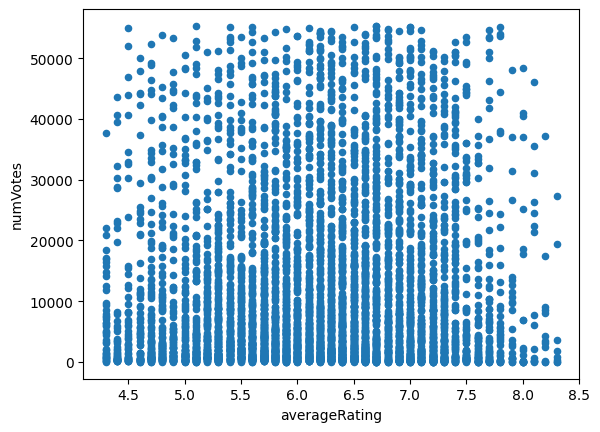

In [37]:
# there's of course a correlation between average rating and number of votes (people prefer to see good movies!)
# so we tackle that by only looking at movies within 2 modified z scores 
# remaining correlation some 0.08, leaves us with around 5K movies
movie_ratings = movie_ratings.query('(averageRating_unit >= -2) and (averageRating_unit <= 2) and (numVotes_unit >= -2) and (numVotes_unit <= 2)')

movie_ratings.plot.scatter(x='averageRating', y='numVotes')
movie_ratings[['averageRating_unit','numVotes_unit', 'year_unit']].corr()

In [38]:
# filter to top K genres
# (each genre needs a color, can't do 20-something colors)
K = 6
genres = movie_ratings.genres.str.split(',').apply(lambda x:set(x))
all_genres = list(set.union(*genres))
setdist_table = [
    list(map(lambda ag: 1 if ag in i else 0, all_genres)) for i in genres
]
setdist_table = np.array(setdist_table)
genre_freq = np.sum(setdist_table,axis=0)
all_genres_sorted = sorted(all_genres, key=lambda g: genre_freq[all_genres.index(g)],reverse=True)
limit_to_genres = all_genres_sorted[:(K+1)]

for genre in all_genres:
    movie_ratings[f'genre_{genre}'] = setdist_table[:,all_genres.index(genre)]
# set all other genres to zero in the hopes that all movies have at least one genre, which will then be one of those we want
for genre in set(all_genres).difference(set(limit_to_genres)):
    genre_col = f'genre_{genre}'
    movie_ratings = movie_ratings[movie_ratings[genre_col]== 0]
len(movie_ratings)

2918

In [39]:

# let's take some movies at random for efficiency
random.seed(1)
N = 10

# TODO would be nice to sample such that we have a uniform distribution of RATING
movie_ratings_sm=None
while True:
    movie_ratings_sm = movie_ratings.sample(N)
    num_movies_per_genre = movie_ratings_sm[list([f'genre_{g}' for g in limit_to_genres])].sum()
    if len(num_movies_per_genre[num_movies_per_genre<2]) > 0:
        print('resampling... there was a genre with less than two movies in the sample')
    else:
        break

movie_ratings = movie_ratings_sm
movie_names = movie_ratings['primaryTitle'] + ' (' + movie_ratings['startYear'] +')'

movie_dists = scidist.squareform(scidist.pdist(movie_ratings[['averageRating_unit','numVotes_unit', 'year_unit']]))

movie_genres = movie_ratings['genres'].str.split(',').apply(lambda g: set(g))
all_genres = set.union(*movie_genres)

setdist_table = [
    list(map(lambda ag: 1 if ag in i else 0, all_genres)) for i in movie_genres
]
setdist_table = np.array(setdist_table)
setdists = scidist.squareform(scidist.pdist(setdist_table, scidist.jaccard))


In [40]:
# haha fun part let's make actual glyph images!
from PIL import Image, ImageDraw, ImageFont

def add_corners(im, rad):
    circle = Image.new('L', (rad * 2, rad * 2), 0)
    draw = ImageDraw.Draw(circle)
    draw.ellipse((0, 0, rad * 2 - 1, rad * 2 - 1), fill=255)
    alpha = Image.new('L', im.size, 255)
    w, h = im.size
    alpha.paste(circle.crop((0, 0, rad, rad)), (0, 0))
    alpha.paste(circle.crop((0, rad, rad, rad * 2)), (0, h - rad))
    alpha.paste(circle.crop((rad, 0, rad * 2, rad)), (w - rad, 0))
    alpha.paste(circle.crop((rad, rad, rad * 2, rad * 2)), (w - rad, h - rad))
    im.putalpha(alpha)
    return im

def expand2square(pil_img, background_color=(0,0,0)):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

fw, fh = (450,450)
margin = 15

for i, c in enumerate(movie_ratings['cover']):
    movie = movie_ratings.iloc[i]
    tconst, ext = c.split('.')
    with Image.open(f'./covers/{c}') as im:
        im2 = expand2square(im.copy())
        im2 = im2.resize((300,300))
        im2 = add_margin(im2, 50,75,100,75,(0,0,0))
        im2 = add_corners(im2, 30)
        w,h = im2.size
        print(tconst)

        fnt = ImageFont.truetype("Arial.ttf", 40)
        d = ImageDraw.Draw(im2)
        d.text((fw/2, 45), movie['startYear'], font=fnt, fill=(255, 255, 255), anchor='ms')
        d.text((margin, 50+395), "{:.2f}".format(movie['averageRating']), font=fnt, fill=(255, 255, 255), anchor='ls')
        d.text((fw-margin, 50+395), "{:,}".format(movie['numVotes']), font=fnt, fill=(255, 255, 255), anchor='rs')
        y = 325+50
        offset = 85
        for star in range(round(movie['averageRating'])):
            x = offset + star*27 + max(0, star-1)*2
            d.ellipse((x,y,x+25,y+25), fill=(255,255,0))
        for star in range(round(movie['averageRating']), 10):
            x = offset + star*27 + max(0, star-1)*2
            d.ellipse((x,y,x+25,y+25), outline=(255,255,0))

        im2.save(f'./imdb10/{tconst}_thumb.png', "PNG")
        # TODO add path to dataframe

tt0118845
tt0088194
tt0091983
tt0841992
tt0118113
tt0099044
tt0100485
tt0085867
tt4935446
tt0405676


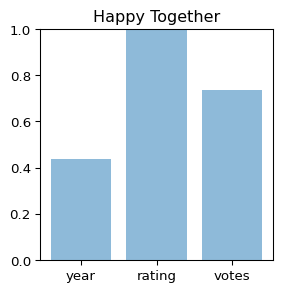

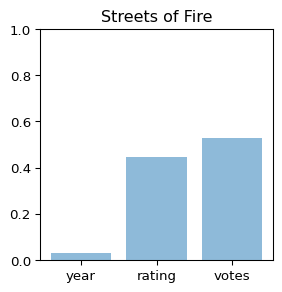

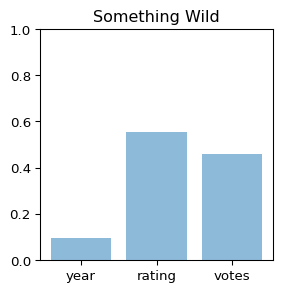

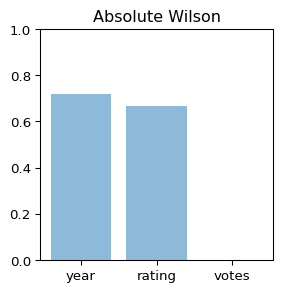

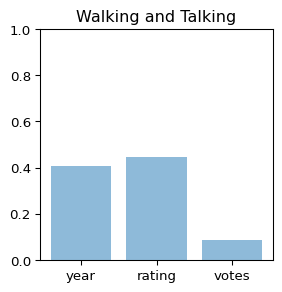

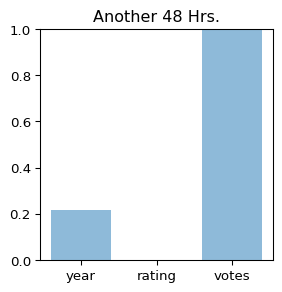

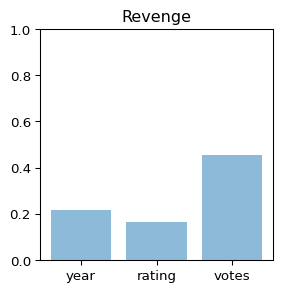

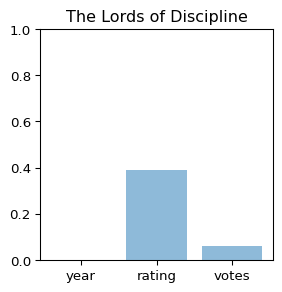

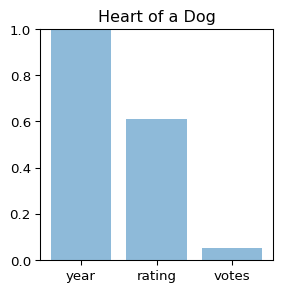

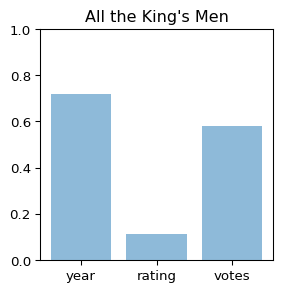

In [41]:
###
### Bar chart glyphs
###

import matplotlib.pyplot as plt
import sys

dpi = 96

variables = ['startYear', 'averageRating', 'numVotes']
short_variables = ['year', 'rating', 'votes']
max_val = [-sys.maxsize] * len(variables)
min_val = [sys.maxsize] * len(variables)

for i, c in enumerate(movie_ratings['cover']):
    movie = movie_ratings.iloc[i]
    for i, var in enumerate(variables):
        val = float(movie[var])
        if max_val[i] < val:
            max_val[i] = val
        if min_val[i] > val:
            min_val[i] = val

for i, c in enumerate(movie_ratings['cover']):
    movie = movie_ratings.iloc[i]
    #print(movie)
    tconst, ext = c.split('.')
    
    bars = []

    for i, var in enumerate(variables):
        bars.append((float(movie[var]) - min_val[i]) / (max_val[i] - min_val[i]))

    

    fig, ax = plt.subplots(figsize=(300/dpi, 300/dpi), dpi=dpi)

    y_pos = np.arange(len(variables))


    plt.bar(y_pos, bars, align='center', alpha=0.5)
    
    plt.ylim(0, 1)
    plt.xticks(y_pos, short_variables)
    plt.title(f'{movie["primaryTitle"]}')

    plt.savefig(f'./imdb10/{tconst}_thumb.png', dpi=dpi)

In [58]:
###
### Radar chart glyphs
###

import matplotlib.pyplot as plt
import sys

dpi = 96

variables = ['startYear', 'averageRating', 'numVotes']
short_variables = ['year', 'rating', 'votes']
max_val = [-sys.maxsize] * len(variables)
min_val = [sys.maxsize] * len(variables)

for i, c in enumerate(movie_ratings['cover']):
    movie = movie_ratings.iloc[i]
    for i, var in enumerate(variables):
        val = float(movie[var])
        if max_val[i] < val:
            max_val[i] = val
        if min_val[i] > val:
            min_val[i] = val

for i, c in enumerate(movie_ratings['cover']):
    movie = movie_ratings.iloc[i]
    #print(movie)
    tconst, ext = c.split('.')
    
    values = []
    N = len(variables)

    for i, var in enumerate(variables):
        values.append((float(movie[var]) - min_val[i]) / (max_val[i] - min_val[i]))

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    values += values[:1]
    
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    ax.figure.set_size_inches(300/dpi, 300/dpi)
    
    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], short_variables, color='grey', size=8)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.ylim(0,1)
    
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.2)

    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)
  

    y_pos = np.arange(len(variables))

    plt.title(f'{movie["primaryTitle"]}')
    plt.tight_layout()

    plt.savefig(f'./imdb10/{tconst}_thumb.png', dpi=dpi)
    plt.clf()

<Figure size 312.5x312.5 with 0 Axes>

In [42]:
with open(f'imdb_{N}.json', 'w', encoding='utf8') as f:
    jsonstr = {
        'glyph_ids': movie_ratings['tconst'].apply(lambda t: f'data/imdb/imdb10/{t}_thumb.png').tolist(),
        'E': movie_names.tolist(),
        'EA': movie_dists.tolist(),
        'SR': movie_genres.apply(lambda s: list(s)).tolist(),
        'S': list(all_genres),
        'SA': setdists.tolist()
    }
    json.dump(jsonstr, f, ensure_ascii=False)